In [1]:
import torch.nn as nn
import torch
import copy
import numpy as np
from numpy import random
from torch.utils.data import Dataset
from torch.autograd import Variable
import matplotlib.pyplot as plt

# Credit: https://cs230-stanford.github.io/pytorch-getting-started.html
class TwoLayerNet(nn.Module):
    def __init__(self, n_input, n_hidden, n_output):
        super(TwoLayerNet, self).__init__()
        self.linear1 = nn.Linear(n_input, n_hidden) 
        self.linear2 = nn.Linear(n_hidden, n_output)
  
    def forward(self, x):
        h = torch.tanh(self.linear1(x))
        y_pred = (self.linear2(h))
        return y_pred


In [2]:
# Generating random normal data

# Parameters for data generation
N, n_input, n_hidden, n_output = 10000, 500, 100, 20 # (N, Input dimension, Hidden dimension, Output dimension)

class customDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
   
    def __getitem__(self, index):
        return self.X[index], self.y[index]

# np.random.seed(10605)
X_train = Variable(torch.randn(N, n_input), requires_grad=True)
y_train = Variable(torch.randn(N, n_output), requires_grad=True)
X_test = Variable(torch.randn(N, n_input))
y_test = Variable(torch.randn(N, n_output))

train_dataset = customDataset(X_train, y_train)
test_dataset = customDataset(X_test, y_test)


----------------------
SGD
----------------------
Epoch: 0, | Loss: 38.2587
Epoch: 1, | Loss: 11.2889
Epoch: 2, | Loss: 3.2748
Epoch: 3, | Loss: 1.6055
Epoch: 4, | Loss: 1.1604
Epoch: 5, | Loss: 1.0394
Epoch: 6, | Loss: 1.0546
Epoch: 7, | Loss: 0.9174
Epoch: 8, | Loss: 1.0230
Epoch: 9, | Loss: 0.9868
----------------------
SVRG
----------------------
Epoch: 0, | Difference: -1626.2874
Epoch: 0, | Loss: 21.6440
Epoch: 1, | Difference: 5.4371
Epoch: 1, | Loss: 1.0195
Epoch: 2, | Difference: -0.4657
Epoch: 2, | Loss: 1.0398
Epoch: 3, | Difference: -4.0269
Epoch: 3, | Loss: 0.9843
Epoch: 4, | Difference: -5.5686
Epoch: 4, | Loss: 1.0461
Epoch: 5, | Difference: -6.2068
Epoch: 5, | Loss: 0.9742
Epoch: 6, | Difference: 3.7461
Epoch: 6, | Loss: 1.0042
Epoch: 7, | Difference: -1.5984
Epoch: 7, | Loss: 1.0606
Epoch: 8, | Difference: 4.8476
Epoch: 8, | Loss: 1.0261
Epoch: 9, | Difference: 0.6951
Epoch: 9, | Loss: 1.0262
----------------------
Adam
----------------------
Epoch: 0, | Loss: 30.0210


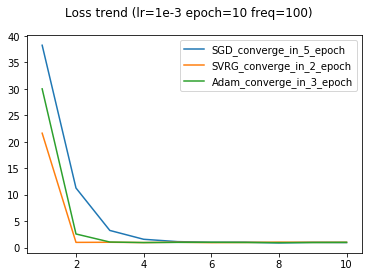

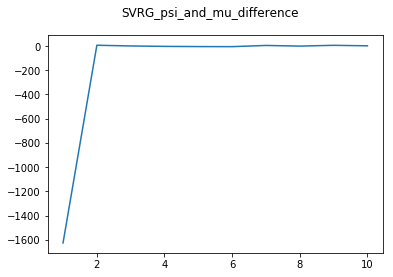

In [3]:
learning_rate = 1e-3
n_epochs = 10
frequency = 100
def initial_model(model):
    model.linear1.weight.data.normal_(0.1, 0.001)
    model.linear1.bias.data.normal_(0.1, 0.001)
    model.linear2.weight.data.normal_(0.1, 0.001)
    model.linear2.bias.data.normal_(0.1, 0.001)


def initial_w_tilde(model):
    w_tilde = copy.deepcopy(model)
    return w_tilde


def zero_grad(model):
    for p in model.parameters():
        if p.grad is not None:
            p.grad.detach_()
            p.grad.zero_()


def cal_gd(model, data_x, data_y):
    gradient = copy.deepcopy(model)
    gradient.train()
    assert (data_x.shape[0] == data_y.shape[0])
    output = gradient(data_x)
    loss = (output - data_y).pow(2).mean()
    loss.backward()

    linear1_w_gd = gradient.linear1.weight.grad.data.clone()
    linear1_b_gd = gradient.linear1.bias.grad.data.clone()
    linear2_w_gd = gradient.linear2.weight.grad.data.clone()
    linear2_b_gd = gradient.linear2.bias.grad.data.clone()
    return [linear1_w_gd, linear1_b_gd, linear2_w_gd, linear2_b_gd]


def set_weight(model, weight_tilde):
    model = copy.deepcopy(weight_tilde)


def update_svrg(model, w_tilde, gradient, lr=learning_rate):
    model.linear1.weight.data.add_(-lr,
                                   model.linear1.weight.grad.data - w_tilde.linear1.weight.grad.data + gradient[0])
    model.linear1.bias.data.add_(-lr,
                                 model.linear1.bias.grad.data - w_tilde.linear1.bias.grad.data + gradient[1])
    model.linear2.weight.data.add_(-lr,
                                   model.linear2.weight.grad.data - w_tilde.linear2.weight.grad.data + gradient[2])
    model.linear2.bias.data.add_(-lr,
                                 model.linear2.bias.grad.data - w_tilde.linear2.bias.grad.data + gradient[3])


def update_sgd(model, lr=learning_rate):
    model.linear1.weight.data.add_(-lr, model.linear1.weight.grad.data)
    model.linear1.bias.data.add_(-lr, model.linear1.bias.grad.data)
    model.linear2.weight.data.add_(-lr, model.linear2.weight.grad.data)
    model.linear2.bias.data.add_(-lr, model.linear2.bias.grad.data)


def update_Adam(model, counter, lr=learning_rate, eps=1e-8):
    for p in list(model.parameters()):
        p.running_momentum = model.beta1 * p.running_momentum + (1 - model.beta1) * p.grad.data
        p.running_adaptor = model.beta2 * p.running_adaptor + (1 - model.beta2) * p.grad.data * p.grad.data

        rescaled_momentum = p.running_momentum.div(1 - model.beta1 ** counter)
        rescaled_adaptor = p.running_adaptor.div(1 - model.beta2 ** counter)
        p.data.add_(-lr * rescaled_momentum.data / (torch.sqrt(rescaled_adaptor) + eps))


def diff_cal(model, gradient):
    p1_list = list(model.parameters())
    diff = np.array([0.0] * len(p1_list))
    # p2_list = list(gradient.parameters())
    p2_list = gradient

    for i in range(len(p1_list)):
        if p1_list[i].shape != p2_list[i].shape:
            print(p1_list[i].shape, p2_list[i].shape)
            print(p1_list, p2_list)
        else:
            diff[i] += (p1_list[i].grad - p2_list[i]).sum()
    return diff


def adam_running_init(model):
    model.beta1 = 0.9
    model.beta2 = 0.999
    for p in list(model.parameters()):
        p.running_momentum = torch.zeros_like(p.data)
        p.running_adaptor = torch.zeros_like(p.data)


def train(optim):
    model.train()
    counter_adam = 0
    loss_list = []
    avg_difference_list = []
    for t in range(n_epochs):  # for each epoch
        avg_loss = 0
        if optim == 'svrg':
            w_tilde = initial_w_tilde(model)
            if t == 0:
                w_tilde.linear1.weight.data.zero_()
                w_tilde.linear1.bias.data.zero_()
                w_tilde.linear2.weight.data.zero_()
                w_tilde.linear2.bias.data.zero_()
            else:
                set_weight(model, w_tilde)
            gradient = cal_gd(model, X_train, y_train)
            avg_difference = np.array([0.0] * len(list(model.parameters())))
        elif optim == 'Adam':
            if t == 0:
                adam_running_init(model)
        for it in range(frequency):  # frequency
            # randomly picking a data point
            random_int = torch.LongTensor([random.randint(0, N - 1)])
            ix = torch.index_select(X_train, 0, random_int)  # index_select(data,axis,index)
            iy = torch.index_select(y_train, 0, random_int)

            if (optim == "svrg"):
                output1 = model(ix)
                loss1 = (output1 - iy).pow(2).mean()
                loss1.backward(retain_graph=True)
                avg_loss += loss1.item()
                output2 = w_tilde(ix)
                loss2 = (output2 - iy).pow(2).mean()
                loss2.backward()

                avg_difference += diff_cal(w_tilde, gradient)
                update_svrg(model, w_tilde, gradient)
                zero_grad(model)
                zero_grad(w_tilde)
            elif optim == "sgd":
                output = model(ix)
                loss_ta = (output - iy).pow(2).mean()
                loss_ta.backward()
                avg_loss += loss_ta.item()
                update_sgd(model)
                zero_grad(model)
            elif optim == 'Adam':
                output = model(ix)
                loss = (output - iy).pow(2).mean()
                loss.backward()
                avg_loss += loss.item()
                counter_adam += 1
                update_Adam(model, counter_adam)
                zero_grad(model)

        if (optim == "svrg"):
            avg_difference /= frequency
            avg_difference_list.append(avg_difference)
            for i, a in enumerate(avg_difference):
                print("Epoch: %d, Weight_id: %d | Difference: %.4f" % (t + 1, i, a))

            
        avg_loss /= frequency
        loss_list.append((t + 1, avg_loss))
        print("Epoch: %d, | Loss: %.4f" % (t, avg_loss))

    loss_list = np.array(loss_list)
    avg_difference_list = np.array(avg_difference_list)
    if optim == 'svrg':
        avg_difference_list = np.hstack((np.arange(n_epochs).reshape((-1, 1)), avg_difference_list))
    return loss_list, avg_difference_list


if __name__ == '__main__':
    # Generating random normal data
    n_epochs = 10
    frequency = 100

    np.random.seed(10605)
    X_train = Variable(torch.randn(N, n_input), requires_grad=True)
    y_train = Variable(torch.randn(N, n_output), requires_grad=True)
    X_test = Variable(torch.randn(N, n_input))
    y_test = Variable(torch.randn(N, n_output))

    train_dataset = customDataset(X_train, y_train)
    test_dataset = customDataset(X_test, y_test)
    # ---------------------------------------------------

    model = TwoLayerNet(n_input, n_hidden, n_output)  # define model
    initial_model(model)
    print('----------------------\nSGD\n----------------------')
    sgd_loss_list, _ = train('sgd')
    plt.plot(sgd_loss_list[:, 0], sgd_loss_list[:, 1])

    # ---------------------------------------------------
    model = TwoLayerNet(n_input, n_hidden, n_output)  # define model
    initial_model(model)
    print('----------------------\nSVRG\n----------------------')
    svrg_loss_list, svrg_difference_list = train('svrg')
    plt.plot(svrg_loss_list[:, 0], svrg_loss_list[:, 1])

    # ---------------------------------------------------
    model = TwoLayerNet(n_input, n_hidden, n_output)  # define model
    initial_model(model)
    print('----------------------\nAdam\n----------------------')
    adam_loss_list, _ = train('Adam')

    plt.plot(adam_loss_list[:, 0], adam_loss_list[:, 1])
    plt.legend(['SGD_converge_in_5_epoch', 'SVRG_converge_in_2_epoch', 'Adam_converge_in_3_epoch'])
    plt.suptitle('Loss trend (lr=1e-3 epoch=10 freq=100)')
    plt.savefig('Loss_trend.png')
    plt.show()

    for i in range(svrg_difference_list.shape[1] - 1):
        plt.plot(svrg_difference_list[:, 0], svrg_difference_list[:, i + 1])
        plot_name = ''
        if i % 2 == 0:
            plot_name = 'SVRG_psi_and_mu_difference_W_{}'.format(i // 2)
        else:
            plot_name = 'SVRG_psi_and_mu_difference_b_{}'.format(i // 2)
        plt.suptitle(plot_name)
        plt.savefig(plot_name + '.png')
        plt.show()